In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation as mad
from scipy.optimize import curve_fit

import lightkurve # Import the lightkurve library
from lightkurve import search_targetpixelfile

In [22]:
def Carter_model(time, tc, f0, delta, T, tau):
    # tc - central transit time
    # f0 - out-of-transit baseline
    # delta - f0*r**2
    # T - 2*tau0*sqrt(1-b**2)
    # tau = 2*tau0*r**2/sqrt(1 - b**2)

    flux = np.zeros_like(time)

    ind = np.abs(time - tc) <= (T/2. - tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta

    ind = ((T/2. - tau/2.) < np.abs(time - tc)) & ((T/2. + tau/2.) > np.abs(time - tc))
    if(len(time[ind]) > 0):
        flux[ind] = f0 - delta + (delta/tau)*(np.abs(time[ind] - tc) - T/2. + tau/2.)

    ind = np.abs(time - tc) >= (T/2. + tau/2.)
    if(len(time[ind]) > 0):
        flux[ind] = f0

    return flux

In [23]:
def get_planet_lightcurve(planet_name):
    # Open a Target Pixel File from MAST and download one data file.
    tpf = search_targetpixelfile(planet_name).download()

    # Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
    lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask).remove_nans()

    time, flux = lc.time.value, lc.flux.value
    
    return time, flux

def calc_detrended_flux(time, flux, coeffs):
    return (flux - np.polyval(coeffs, time))/np.polyval(coeffs, time)
    
def calc_sigma(detrended_flux):
    # Use the standard deviation of all the data to estimate the uncertainty
    return np.ones_like(detrended_flux)*mad(detrended_flux)

def fit_transit_ephemeris(time, trial_T0, trial_period):
    # Phase fold on the trial period
    folded_time = ((time - trial_T0) % trial_period)
    
    ret_val = Carter_model(folded_time, trial_T0, *transit_shape_params[1:])
    
    return ret_val

C:\Users\seanh\Anaconda3\Lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


82060440.0 82060438.47004032


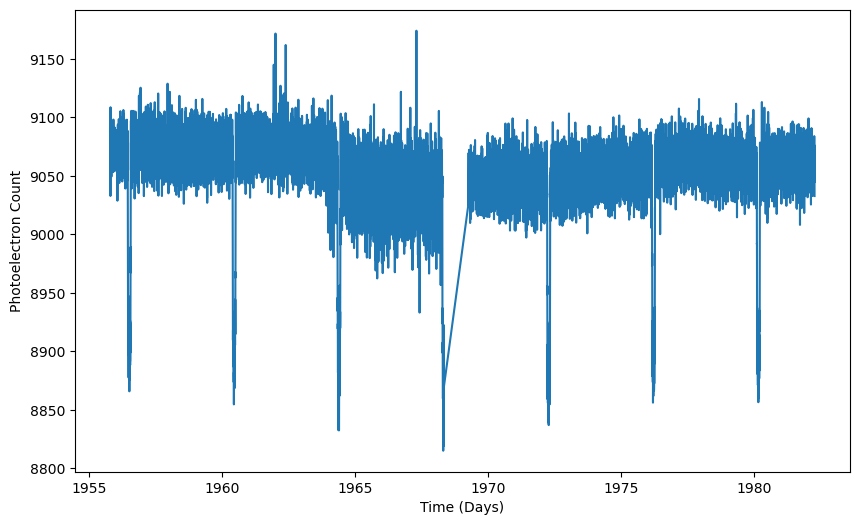

In [36]:
planet_name = "XO-1b"

orbital_period = 3.94150468 # https://exoplanetarchive

time, flux = get_planet_lightcurve(planet_name)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(time, flux)

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Photoelectron Count" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "Raw Lightcurve"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")
print(np.median(flux**2),np.median(flux)**2)

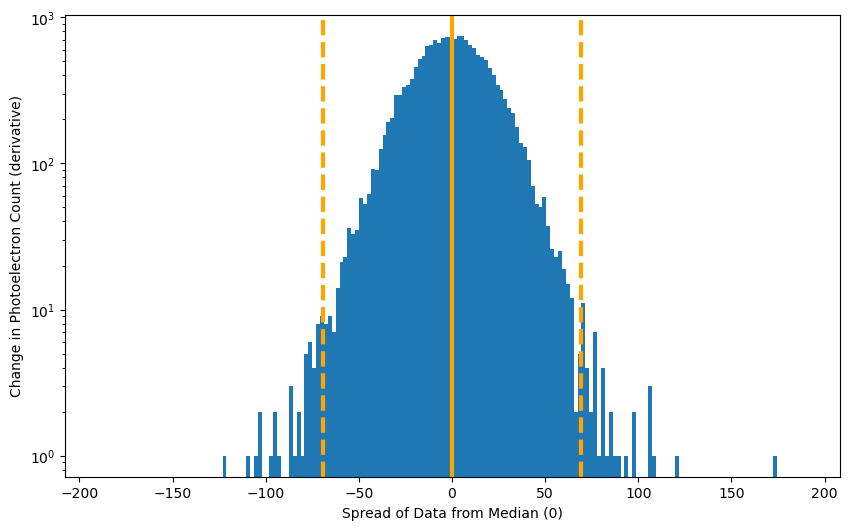

In [32]:
# Calculate the derivative
df = np.diff(flux)
num_sigma = 5

# Calculate the median value
med = np.median(df)
# Calculate the standard deviation
std = mad(df)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Make a histogram showing the distribution of derivative values.
ax.hist(df, bins='auto');
ax.set_yscale('log') # Make it easier to the outliers

# Add in lines showing the expected width of the distribution if it were just Gaussian.
ax.axvline(med, lw=3, color='orange')
ax.axvline(med - num_sigma*std, lw=3, color='orange', ls='--')
ax.axvline(med + num_sigma*std, lw=3, color='orange', ls='--')

ax.set_xlim([-3*num_sigma*std + med, 3*num_sigma*std + med])

x_label_text = "Spread of Data from Median (0)" # Label your x-axis
y_label_text = "Change in Photoelectron Count (derivative)" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "Derivatives"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

C:\Users\seanh\Anaconda3\Lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


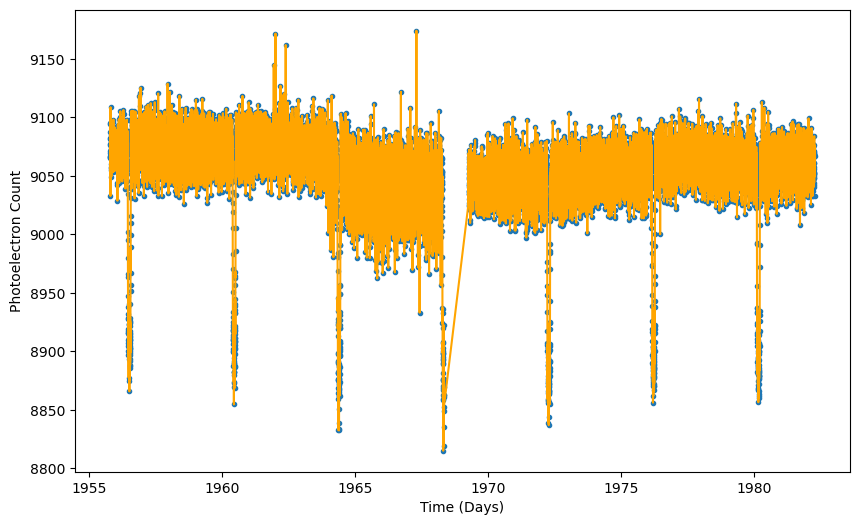

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Let's compare the original data with outliers to the processed data with outliers removed.
time, flux = get_planet_lightcurve(planet_name)
ax.plot(time, flux, marker='.', ls='')

# Find the outlier points
df = np.diff(flux)
ind = np.abs(df - med) > num_sigma*std

# Append one extra element - we have to re-jigger the data a bit since diff returns one fewer element.
ind = np.append(ind, False)
time = time[~ind][:-2]
flux = flux[~ind][:-2]
ax.plot(time, flux, color='orange')

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Photoelectron Count" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "Outlier Processed"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

C:\Users\seanh\Anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


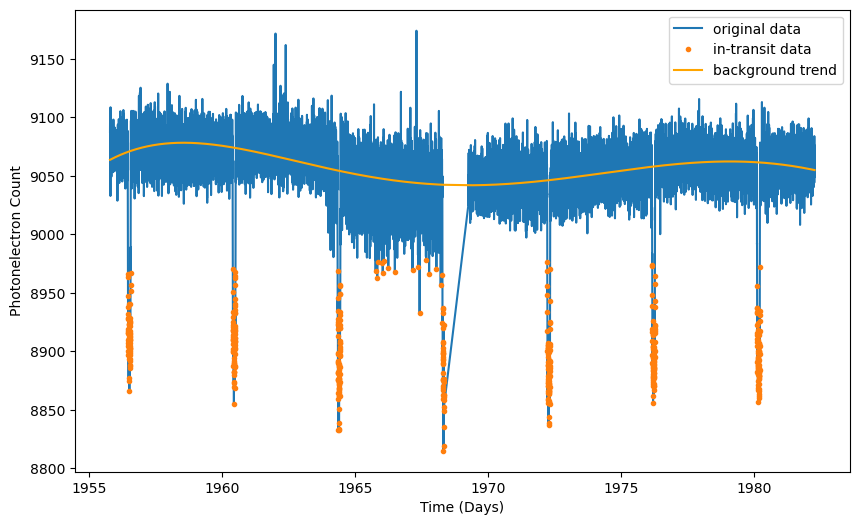

In [31]:
num_sigma = 6.
polynomial_degree = 40

med = np.median(flux)
std = mad(flux)
ind = (med - flux) > num_sigma*std

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(time, flux, label="original data")
plt.plot(time[ind], flux[ind], ls='', marker='.', label="in-transit data")

# Fit a polynomial
coeffs = np.polyfit(time[~ind], flux[~ind], polynomial_degree)
detrended_flux = calc_detrended_flux(time, flux, coeffs)

ax.plot(time, np.polyval(coeffs, time), color='orange', label="background trend")
ax.legend(loc='best')

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Photonelectron Count" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "Polyfit"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

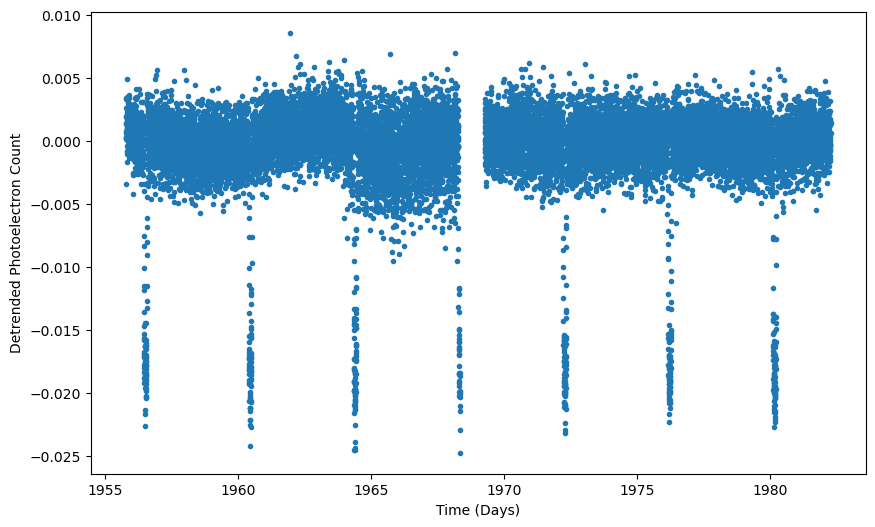

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# And now let's plot the detrended/outlier-filtered data
ax.scatter(time, detrended_flux, marker='.')

x_label_text = "Time (Days" # Label your x-axis
y_label_text = "Detrended Photoelectron Count" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)

# Save your figure - use another name that describes the data plotted
figure_name = "figure.png"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

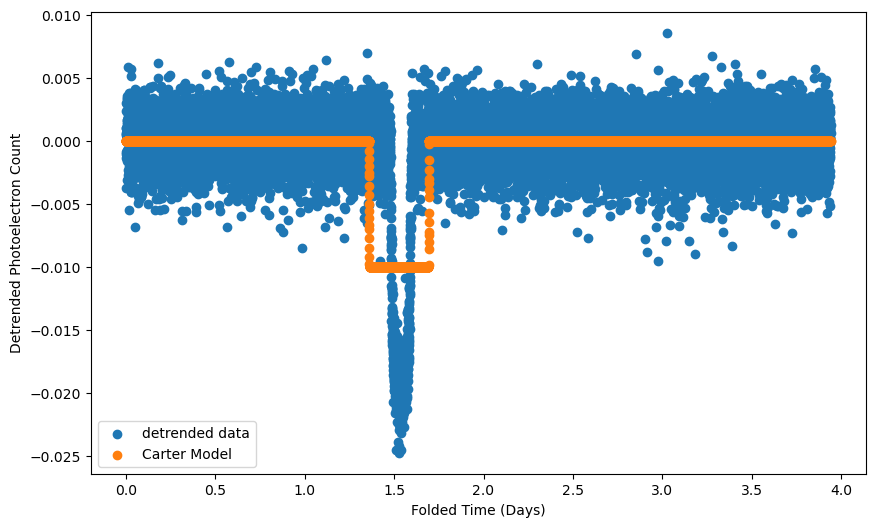

In [19]:

# Phase-folded time
folded_time = (time % orbital_period)
# Detrend the flux
detrended_flux = calc_detrended_flux(time, flux, coeffs)

# The background value is very nearly the median for all the data
background = np.median(detrended_flux)

# ratio of the planet's to the star's radius - usually about 0.1
ratio_of_planet_to_star_radius = 0.1

# Let's guess that the central transit time is the time when the flux drops to its minimum value
t0 = (time % orbital_period)[np.argmin(detrended_flux)]

# transit duration - probably a few hours, but be sure to tweak it to what your eyeball says
duration = 4./24. # Divide through 24 hours to convert from hours to days.

# Let's set our initial guesses and check them
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius**2, 
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

fig = plt.figure(figsize=(10, 6))
plt.scatter(folded_time, detrended_flux, label = 'detrended data')
plt.scatter(folded_time, Carter_model(folded_time, *initial_guesses), label = 'Carter Model')
plt.legend(loc='best')

x_label_text = "Folded Time (Days)" # Label your x-axis
y_label_text = "Detrended Photoelectron Count" # Label your y-axis
plt.xlabel(x_label_text)
plt.ylabel(y_label_text)



# Save your figure - use another name that describes the data plotted
figure_name = "Folded 1"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

best fit values: 1.53655, 1.38568e-05, 0.0186733, 0.102393, 0.0190116
best fit uncertainties: 0.000135819, 1.3387e-05, 9.16437e-05, 0.000287212, 0.000478055


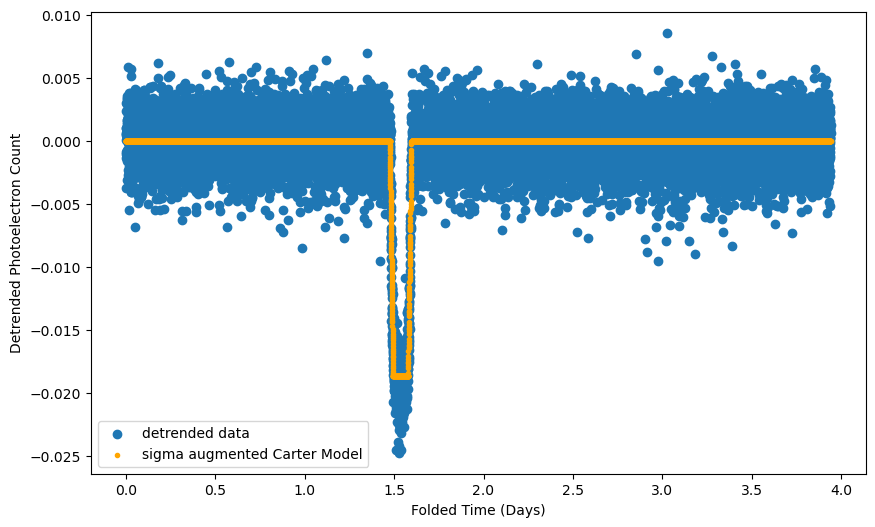

In [10]:
#Reset initial guesses
initial_guesses = np.array([t0, background, ratio_of_planet_to_star_radius, 
                            2.*duration, 2.*duration*ratio_of_planet_to_star_radius**2])

# Estimate per-point uncertainties
sigma = calc_sigma(detrended_flux)

# Fit folded transit
transit_shape_params, pcov = curve_fit(Carter_model, folded_time, detrended_flux,
                      p0=initial_guesses, sigma=sigma)
transit_shape_params_unc = np.sqrt(np.diag(pcov))
print("best fit values: %g, %g, %g, %g, %g" %\
      (transit_shape_params[0], 
       transit_shape_params[1], 
       transit_shape_params[2],
       transit_shape_params[3], 
       transit_shape_params[4]))
print("best fit uncertainties: %g, %g, %g, %g, %g" % (transit_shape_params_unc[0], 
                                                      transit_shape_params_unc[1], 
                                                      transit_shape_params_unc[2], 
                                                      transit_shape_params_unc[3], 
                                                      transit_shape_params_unc[4]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Check the fit
ax.scatter(folded_time, detrended_flux, label = 'detrended data')
ax.scatter(folded_time, Carter_model(folded_time, *transit_shape_params), marker='.', color='orange', label = 'sigma augmented Carter Model')

x_label_text = "Folded Time (Days)" # Label your x-axis
y_label_text = "Detrended Photoelectron Count" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)
ax.legend(loc='best')

# Save your igure - use another name that describes the data plotted
figure_name = "Folded 2"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")


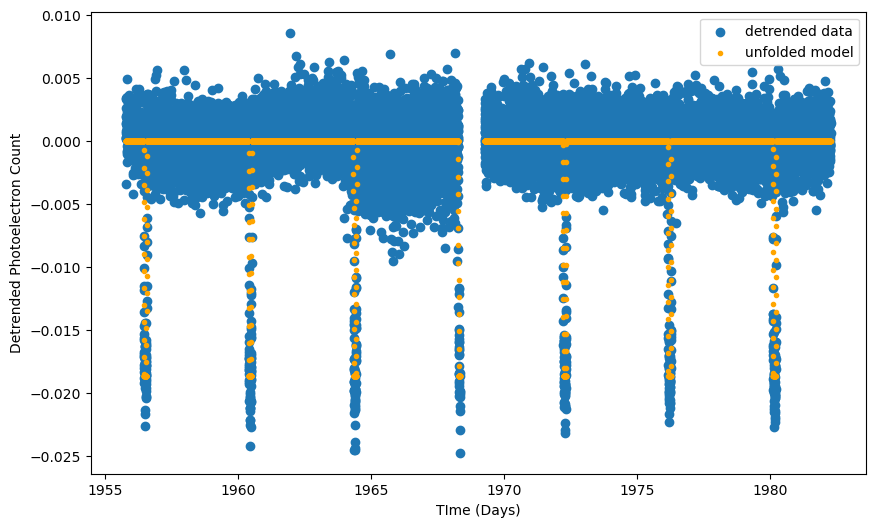

In [18]:
# Again let's set our initial guesses and check how they look
T0 = 0.5*transit_shape_params[0] # This number has to be VERY close to the right number.
ephemeris_initial_guesses = np.array([T0, orbital_period])
initial_guess_transits = fit_transit_ephemeris(time, *ephemeris_initial_guesses)

fig = plt.figure(figsize=(10, 6))
plt.scatter(time, detrended_flux, label = 'detrended data')
plt.scatter(time, initial_guess_transits, color='orange', marker='.', label = 'unfolded model')
plt.ylabel('Detrended Photoelectron Count')
plt.xlabel('TIme (Days)')
plt.legend()

figure_name = "Unfolded"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")

[0.76827408 3.94150468]
best fit T0, period: 0.768274, 3.9415
best fit T0, period unc: 0.00138638, 5.57004e-06


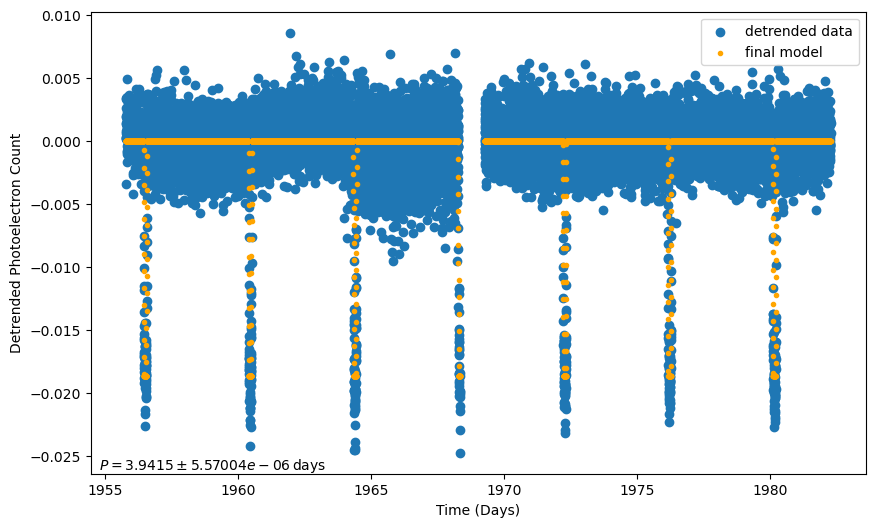

In [12]:

# Now let's do our fit.

ephemeris_fit_params, pcov = curve_fit(fit_transit_ephemeris, time, detrended_flux, 
                       p0=ephemeris_initial_guesses, sigma=sigma)
ephemeris_fit_params_unc = np.sqrt(np.diag(pcov))
print(ephemeris_initial_guesses)
print("best fit T0, period: %g, %g" % (ephemeris_fit_params[0], ephemeris_fit_params[1]))
print("best fit T0, period unc: %g, %g" % (ephemeris_fit_params_unc[0], ephemeris_fit_params_unc[1]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

ax.scatter(time, detrended_flux, label = 'detrended data')
ax.scatter(time, fit_transit_ephemeris(time, *ephemeris_fit_params), color='orange', marker='.', label = 'final model')

# Include your final result on the figure
ax.text(0.01, 0.01, r'$P = %g\pm%g\,{\rm days}$' % (ephemeris_fit_params[1], ephemeris_fit_params_unc[1]), 
        transform=ax.transAxes)

x_label_text = "Time (Days)" # Label your x-axis
y_label_text = "Detrended Photoelectron Count" # Label your y-axis
ax.set_xlabel(x_label_text)
ax.set_ylabel(y_label_text)
ax.legend(loc='best')

# Save your figure - use another name that describes the data plotted
figure_name = "Final"
fig.savefig(figure_name, dpi=300, bbox_inches="tight")